In [1]:
# Install required libraries
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

# Import libraries for downloading the dataset
import opendatasets as od
import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

# Download dataset from Kaggle
dataset_url = 'https://www.kaggle.com/datasets/punfake/resisc45'
od.download(dataset_url)

# Set the path to the image folder
data_path = 'resisc45/NWPU-RESISC45'

# Initialize image data and labels
image_data = []
labels = []

# Load the image dataset
for root, dirs, files in os.walk(data_path):
    for file in files:
        if file.endswith(".jpg"):
            # Read the image
            image = cv2.imread(os.path.join(root, file))
            image = cv2.resize(image, (32, 32))  # Resize
            image = img_to_array(image)
            image_data.append(image)

            # Use the folder name as the label
            label = root.split(os.path.sep)[-1]
            labels.append(label)

# Convert to numpy arrays and normalize the images
image_data = np.array(image_data, dtype="float") / 255.0
labels = np.array(labels)

# Binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(image_data, labels, test_size=0.2, random_state=42)

print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')

# Define the teacher model (more layers)
def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define the student model (fewer layers)
def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

input_shape = (32, 32, 3)  # Updated input shape
num_classes = len(lb.classes_)

# Build teacher and student models
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=8, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

# Define distillation loss function
def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=0.1):
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_true = tf.keras.activations.softmax(y_true / temperature)
    y_pred = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
    soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    return alpha * soft_loss + (1. - alpha) * hard_loss


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: akshayanand2002
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/punfake/resisc45


100%|██████████| 407M/407M [00:07<00:00, 58.6MB/s]



Training samples: 25200, Testing samples: 6300
Epoch 1/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 279s 353ms/step - accuracy: 0.0459 - loss: 3.6755 - val_accuracy: 0.1257 - val_loss: 3.2392 - learning_rate: 0.0100
Epoch 2/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 319s 349ms/step - accuracy: 0.1631 - loss: 3.0442 - val_accuracy: 0.2635 - val_loss: 2.5879 - learning_rate: 0.0100
Epoch 3/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 324s 353ms/step - accuracy: 0.2726 - loss: 2.5591 - val_accuracy: 0.3813 - val_loss: 2.1696 - learning_rate: 0.0100
Epoch 4/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 319s 349ms/step - accuracy: 0.3636 - loss: 2.2173 - val_accuracy: 0.4244 - val_loss: 1.9927 - learning_rate: 0.0100
Epoch 5/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 322s 349ms/step - accuracy: 0.4320 - loss: 1.9610 - val_accuracy: 0.4702 - val_loss: 1.8077 - learning_rate: 0.0100
Epoch 6/8
788/788 ━━━━━━━━━━━━━━━━━━━━ 323s 350ms/step - accuracy: 0.4951 - loss: 1.7098 - val_accuracy: 0.4983 - val_loss: 1.7051 - learning_rate: 0.0100
Epoch 7/8
788/788 ━━━━

In [2]:
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

Teacher test accuracy: 60.02%


In [3]:
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

Epoch 1/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 72s 86ms/step - accuracy: 0.0411 - loss: 3.8067 - val_accuracy: 0.1435 - val_loss: 3.8066 - learning_rate: 0.0010
Epoch 2/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 81s 85ms/step - accuracy: 0.1542 - loss: 3.8066 - val_accuracy: 0.2659 - val_loss: 3.8065 - learning_rate: 0.0010
Epoch 3/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step - accuracy: 0.2662 - loss: 3.8065 - val_accuracy: 0.3576 - val_loss: 3.8064 - learning_rate: 0.0010
Epoch 4/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 82s 81ms/step - accuracy: 0.3560 - loss: 3.8064 - val_accuracy: 0.4005 - val_loss: 3.8063 - learning_rate: 0.0010
Epoch 5/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 66s 83ms/step - accuracy: 0.3944 - loss: 3.8063 - val_accuracy: 0.4549 - val_loss: 3.8063 - learning_rate: 0.0010
Epoch 6/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 82s 83ms/step - accuracy: 0.4504 - loss: 3.8063 - val_accuracy: 0.4817 - val_loss: 3.8062 - learning_rate: 0.0010
Epoch 7/10
788/788 ━━━━━━━━━━━━━━━━━━━━ 63s 80ms/step - accuracy: 0.4830 - l

In [4]:
# Evaluate models
#teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
#print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

Student test accuracy: 54.57%


In [5]:
# Evaluate the teacher model
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)

print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Generate predictions from the teacher model
teacher_preds_probs = teacher.predict(x_test)
teacher_preds = np.argmax(teacher_preds_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report for the teacher model
print("=== Teacher Model Classification Report ===")
print(classification_report(y_true, teacher_preds, target_names=lb.classes_))

Teacher test accuracy: 60.02%
197/197 ━━━━━━━━━━━━━━━━━━━━ 16s 80ms/step
=== Teacher Model Classification Report ===
                       precision    recall  f1-score   support

             airplane       0.56      0.70      0.62       142
              airport       0.60      0.41      0.49       136
     baseball_diamond       0.80      0.52      0.63       151
     basketball_court       0.40      0.24      0.30       147
                beach       0.62      0.78      0.69       138
               bridge       0.66      0.77      0.71       137
            chaparral       0.90      0.87      0.88       122
               church       0.60      0.42      0.49       171
    circular_farmland       0.69      0.73      0.71       141
                cloud       0.82      0.78      0.80       157
      commercial_area       0.48      0.42      0.45       154
    dense_residential       0.53      0.69      0.60       153
               desert       0.85      0.78      0.81       158


788/788 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step
=== Classification Report for Alpha: 0.0 ===
                       precision    recall  f1-score   support

             airplane       0.81      0.56      0.66       142
              airport       0.42      0.33      0.37       136
     baseball_diamond       0.63      0.65      0.64       151
     basketball_court       0.36      0.24      0.29       147
                beach       0.86      0.73      0.79       138
               bridge       0.68      0.77      0.72       137
            chaparral       0.75      0.92      0.82       122
               church       0.44      0.49      0.46       171
    circular_farmland       0.81      0.68      0.74       141
                cloud       0.73      0.82      0.77       157
      commercial_area       0.37      0.50      0.43       154
    dense_residential       0.48      0.66      0.55       153
               desert       0.90      0.84      0.

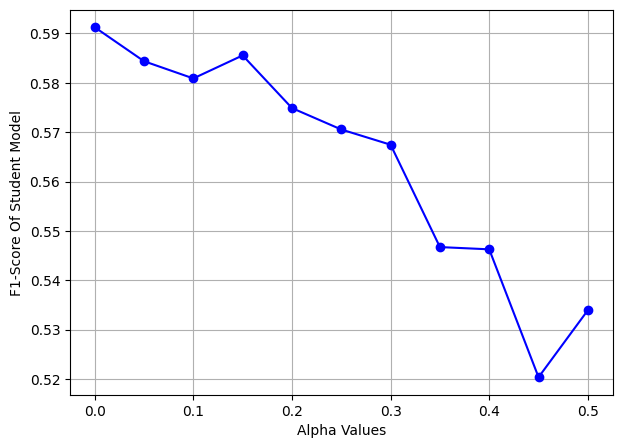

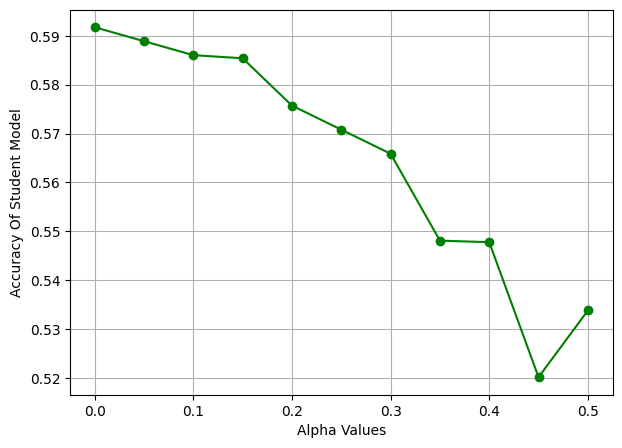

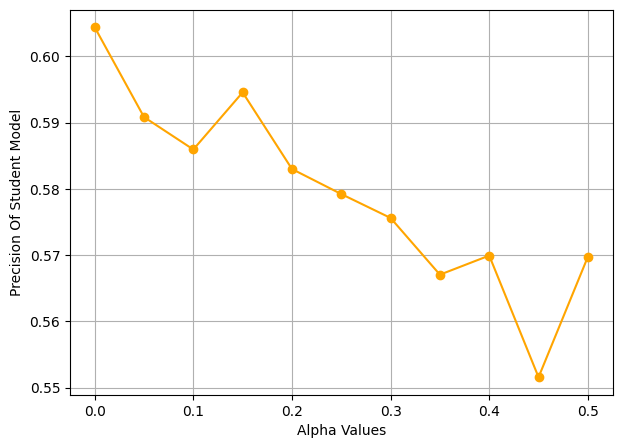

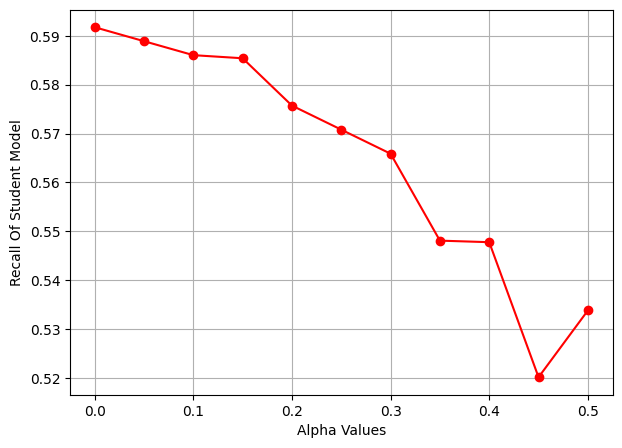

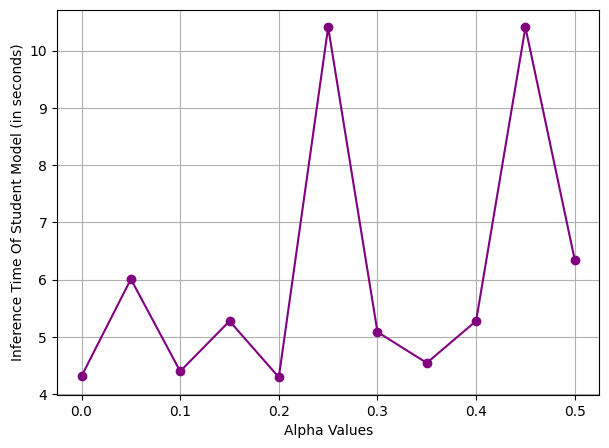

In [6]:
#alpha_values = [0.01, 0.1, 0.2, 0.3, 0.4]
alpha_values = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
f1_scores = []
accuracies = []
precisions = []
recalls = []
inference_times = []

teacher_preds = teacher.predict(x_train)

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given model and alpha
def evaluate_student_with_alpha(alpha):
    # Redefine distillation loss function with current alpha
    def distillation_loss(y_true, y_pred, teacher_preds, temperature=3.0, alpha=alpha):
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_true = tf.keras.activations.softmax(y_true / temperature)
        y_pred = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds = tf.keras.activations.softmax(teacher_batch_preds / temperature)
        soft_loss = tf.keras.losses.categorical_crossentropy(teacher_batch_preds, y_pred)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return alpha * soft_loss + (1. - alpha) * hard_loss

    # Compile the student model with the new distillation loss
    student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
                    metrics=['accuracy'])

    # Train the student model
    student.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    # Predict and evaluate
    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Calculate and store F1-score, accuracy, precision, recall, and inference time
    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Append the results
    f1_scores.append(f1)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    inference_times.append(inference_time)

    # Print classification report
    print(f"=== Classification Report for Alpha: {alpha} ===")
    print(classification_report(y_true, y_pred, target_names=lb.classes_))
    print(f"Inference Time: {inference_time:.4f} seconds\n")
    print(f"Alpha: {alpha} - F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Run evaluation for each alpha
for alpha in alpha_values:
    evaluate_student_with_alpha(alpha)

# Plot F1-Score vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, f1_scores, marker='o', color='b')
plt.xlabel("Alpha Values")
plt.ylabel("F1-Score Of Student Model")
plt.grid(True)
plt.savefig("f1_score_vs_alpha.pdf")
plt.show()

# Plot Accuracy vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, accuracies, marker='o', color='g')
plt.xlabel("Alpha Values")
plt.ylabel("Accuracy Of Student Model")
plt.grid(True)
plt.savefig("accuracy_vs_alpha.pdf")
plt.show()

# Plot Precision vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, precisions, marker='o', color='orange')
plt.xlabel("Alpha Values")
plt.ylabel("Precision Of Student Model")
plt.grid(True)
plt.savefig("precision_vs_alpha.pdf")
plt.show()

# Plot Recall vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, recalls, marker='o', color='red')
plt.xlabel("Alpha Values")
plt.ylabel("Recall Of Student Model")
plt.grid(True)
plt.savefig("recall_vs_alpha.pdf")
plt.show()

# Plot Inference Time vs. Alpha
plt.figure(figsize=(7, 5))
plt.plot(alpha_values, inference_times, marker='o', color='purple')
plt.xlabel("Alpha Values")
plt.ylabel("Inference Time Of Student Model (in seconds)")
plt.grid(True)
plt.savefig("inference_time_vs_alpha.pdf")
plt.show()